In [176]:
import math
import random
import glob
import os
import numpy as np

import cv2
import numbers
import collections

import torch
from torch.utils import data

import IPython.display

from utils import resize_image, load_image

# default list of interpolations
_DEFAULT_INTERPOLATIONS = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC]


In [177]:
def rescale(size, img):
    interpolation = cv2.INTER_LINEAR
    if isinstance(size, int):
        #################################################################################
        # Fill in the code here
        #################################################################################
        h, w, c = img.shape

        min_dim = min(h, w)
        max_dim = max(h, w)

        new_max = int(size * max_dim / min_dim)
        new_dims = (new_max, size)
        if h > w:
            new_dims = (size, new_max)
        img = resize_image(img, new_dims, interpolation)
        return img
    else:
        #################################################################################
        # Fill in the code here
        #################################################################################
        img = resize_image(img, (size[0], size[1]), interpolation)
        return img

In [180]:
#################################################################################
# These are helper functions or functions for demonstration
# You won't need to modify them
#################################################################################

class Compose(object):
    """Composes several transforms together.

    Args:
      transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
      >>> Compose([
      >>>     Scale(320),
      >>>     RandomSizedCrop(224),
      >>> ])
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
          img = t(img)
        return img

    def __repr__(self):
        repr_str = ""
        for t in self.transforms:
            repr_str += t.__repr__() + '\n'
        return repr_str


In [181]:
class RandomHorizontalFlip(object):
    """Horizontally flip the given numpy array randomly
     (with a probability of 0.5).
    """
    def __call__(self, img):
        """
        Args:
            img (numpy array): Image to be flipped.

        Returns:
            numpy array: Randomly flipped image
        """
        if random.random() < 0.5:
            img = cv2.flip(img, 1)
            return img
        return img

    def __repr__(self):
        return "Random Horizontal Flip"

In [182]:
#################################################################################
# You will need to fill in the missing code in these classes
#################################################################################
class Scale(object):
    """Rescale the input numpy array to the given size.

    Args:
      size (sequence or int): Desired output size. If size is a sequence like
          (w, h), output size will be matched to this. If size is an int,
          smaller edge of the image will be matched to this number.
          i.e, if height > width, then image will be rescaled to
          (size, size * height / width)

      interpolations (list of int, optional): Desired interpolation.
      Default is ``CV2.INTER_NEAREST|CV2.INTER_LINEAR|CV2.INTER_CUBIC``
      Pass None during testing: always use CV2.INTER_LINEAR
    """
    def __init__(self, size, interpolations=_DEFAULT_INTERPOLATIONS):
        assert (isinstance(size, int)
                or (isinstance(size, collections.Iterable)
                    and len(size) == 2)
               )
        self.size = size
        # use bilinear if interpolation is not specified
        if interpolations is None:
            interpolations = [cv2.INTER_LINEAR]
        assert isinstance(interpolations, collections.Iterable)
        self.interpolations = interpolations

    def __call__(self, img):
        """
        Args:
            img (numpy array): Image to be scaled.

        Returns:
            numpy array: Rescaled image
        """
        # sample interpolation method
        interpolation = random.sample(self.interpolations, 1)[0]

        # scale the image
        if isinstance(self.size, int):
            #################################################################################
            # Fill in the code here
            #################################################################################
            h, w, c = img.shape

            min_dim = min(h, w)
            max_dim = max(h, w)

            new_min = int(self.size * max_dim / min_dim)
            new_dims = (new_min, self.size) if h < w else (self.size, new_min)
            
            img = resize_image(img, new_dims, interpolation)
            return img
        else:
            #################################################################################
            # Fill in the code here
            #################################################################################
            img = resize_image(img, self.size, interpolation)
            return img

    def __repr__(self):
        if isinstance(self.size, int):
            target_size = (self.size, self.size)
        else:
            target_size = self.size
        return "Scale [Exact Size ({:d}, {:d})]".format(target_size[0], target_size[1])



In [338]:
class RandomSizedCrop(object):
    """Crop the given numpy array to random area and aspect ratio.

    A crop of random area of the original size with a random aspect ratio is made.
    This crop is finally resized to a fixed given size. This is widely used
    as data augmentation for training image classification models.

    Args:
      size (sequence or int): size of target image. If size is a sequence like
          (w, h), output size will be matched to this. If size is an int,
          output size will be (size, size).
      interpolations (list of int, optional): Desired interpolation.
      Default is ``CV2.INTER_NEAREST|CV2.INTER_LINEAR|CV2.INTER_CUBIC``
      area_range (list of int): range of the areas to sample from
      ratio_range (list of int): range of aspect ratio to sample from
      num_trials (int): number of sampling trials
    """

    def __init__(self, size, interpolations=_DEFAULT_INTERPOLATIONS,
               area_range=(0.25, 1.0), ratio_range=(0.8, 1.2), num_trials=10):
        self.size = size
        if interpolations is None:
            interpolations = [cv2.INTER_LINEAR]
        assert isinstance(interpolations, collections.Iterable)
        self.interpolations = interpolations
        self.num_trials = int(num_trials)
        self.area_range = area_range
        self.ratio_range = ratio_range

    def __call__(self, img):
        # sample interpolation method
        interpolation = random.sample(self.interpolations, 1)[0]
        for attempt in range(self.num_trials):
            # sample target area / aspect ratio from area range and ratio range
            area = img.shape[0] * img.shape[1]
            target_area = random.uniform(self.area_range[0], self.area_range[1]) * area
            aspect_ratio = random.uniform(self.ratio_range[0], self.ratio_range[1])

            #################################################################################
            # Fill in the code here
            #################################################################################
            # compute the width and height
            # note that there are two possibilities TODO what??
            # crop the image and resize to output size
            h, w, x = img.shape
            new_w = int(math.sqrt(target_area / aspect_ratio))
            new_h = int(new_w * aspect_ratio)
            
            #following instructor piazza comment that regions outside of image dims should be skipped
            if new_h <= h and new_w <= w:
                crop_start_h = random.randint(0, img.shape[0] - new_h)
                crop_end_h = crop_start_h + new_h
                crop_start_w = random.randint(0, img.shape[1] - new_w)
                crop_end_w = crop_start_w + new_w

                img = img[crop_start_h:crop_end_h, crop_start_w:crop_end_w]
                im_scale = Scale((self.size, self.size), interpolations=self.interpolations)
                img = im_scale(img)
                return img.astype(int)
        
        # Fall back
        if isinstance(self.size, int):
            im_scale = Scale(self.size, interpolations=self.interpolations)
            img = im_scale(img)
            #################################################################################
            # Fill in the code here
            #################################################################################
            # with a square sized output, the default is to crop the patch in the center
            # (after all trials fail)
            h, w, x = img.shape
            center_h = int(h/2)
            center_w = int(w/2)
            half_size = self.size/2
            
            crop_start_h = int(max(0, center_h - half_size))
            crop_end_h = int(min(h, center_h + half_size))
            crop_start_w = int(max(0, center_w - half_size))
            crop_end_w = int(min(w, center_w + half_size))
            
            img = img[crop_start_h:crop_end_h, crop_start_w:crop_end_w]
            return img.astype(int)
        else:
            # with a pre-specified output size, the default crop is the image itself
            im_scale = Scale(self.size, interpolations=self.interpolations)
            img = im_scale(img)
            return img.astype(int)

    def __repr__(self):
        if isinstance(self.size, int):
              target_size = (self.size, self.size)
        else:
              target_size = self.size
        return "Random Crop" + \
               "[Size ({:d}, {:d}); Area {:.2f} - {:.2f}; Ratio {:.2f} - {:.2f}]".format(
                target_size[0], target_size[1],
                self.area_range[0], self.area_range[1],
                self.ratio_range[0], self.ratio_range[1])

In [317]:
class RandomColor(object):
    """Perturb color channels of a given image
    Sample alpha in the range of (-r, r) and multiply 1 + alpha to a color channel.
    The sampling is done independently for each channel.

    Args:
      color_range (float): range of color jitter ratio (-r ~ +r) max r = 1.0
    """
    def __init__(self, color_range):
        self.color_range = color_range

    def __call__(self, img):
        #################################################################################
        # Fill in the code here
        #################################################################################
        jitter = np.random.uniform(max(0.0, 1 - self.color_range), min(1 + self.color_range, 1.0), img.shape[-1])
        img = (img * jitter).astype(int)
        return img

    def __repr__(self):
        return "Random Color [Range {:.2f} - {:.2f}]".format(
                1-self.color_range, 1+self.color_range)


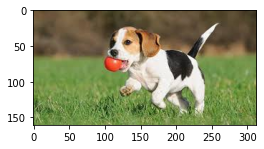

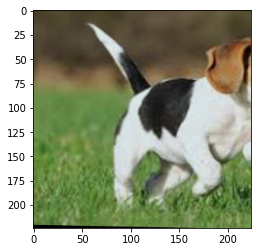

In [352]:
# import matplotlib.pyplot as plt
# from utils import load_image, save_image
# fn = "/Users/grandevelia1/Documents/school/fall_2022/771_cv/work/image_processing/samples/dog.jpg"

# img = load_image(fn)
# # create an empty list and add transforms one by one
# # create an empty list and add transforms one by one
# transforms = []
# transforms.append(Scale(320))
# transforms.append(RandomHorizontalFlip())
# transforms.append(RandomColor(0.15))
# transforms.append(RandomRotate(30))
# transforms.append(RandomSizedCrop(224))
# comp_transforms = Compose(transforms)
# t_img = comp_transforms(img)
# # let's take a look at the results!
# plt.figure(figsize=(4,4)); plt.imshow(img);
# plt.figure(figsize=(4,4)); plt.imshow(t_img);

In [191]:
def display_img(img, fn='test.jpg'):
    cv2.imwrite(fn, img)
    IPython.display.display(IPython.display.Image(fn))

In [192]:
def max_dims(m, c):
    '''
        Calculates the length and height
            for the vertical/horizontal rectangle with maximum area
            contained in the rotated rectangle with sides defined as:
            
        top: y = mx + b
        bottom: y = mx + a
        left: y = -x/m + c
        
        if h < w (and analagously for h > w):
        we define x = 0 to be the top left corner (b = c), and intercept of bottom to be y = 0 = a,
            so intercepts all cancel to 0 (see report)
        @param m: slope
        @param c: y-intercept of top-left corner
        
        returns a tuple with (
            0: short side size of the max rectangle
            1: long side size of the max rectangle
        )
    '''
    M = m + 1/m
    best_x = ((m * m) * c - M * m * c)/(-2 * M)
    zh = best_x * M
    zl = (-M * best_x/m) + (M * c) - (m * x)
    print("best_x", best_x, "M", M)
    return zl, zh

def rect_lines(theta, s, l):
    '''
        Calculates the slope and horizontal/vertical projections for the rectangle with dims s X l
            (shorter dim, longer dim)
            which has been rotated by theta degrees about its center
        
        Examples below assume a starting rect with l > h.
        returns a tuple with 
            0: slope of long side assuming it was horizontal before rotation
                Final rectangle will be invariant to this
                since we have slopes m and -1/m for bounding lines regardless
            1: y-intercept of top-left corner
        )
    '''
    theta = math.radians(theta)
    sin = math.sin(theta)
    cos = math.cos(theta)
    ss = l * sin
    ls = l * cos
    print("ss", ss, "ls", ls)
    m = ss/ls

    #We set the bottom-left intercept to the origin so a = 0, and the top left to by at x=0
    #Then the bottom-left rotated corner must be at x = h*sin(theta)
    bl_x = s * sin
    # Then its y-coordinate is given by either line. Use the bottom since that intercept is 0:
    bl_y = m * bl_x
    print("bl_x:", bl_x, "bl_y:", bl_y)
    c = bl_y + bl_x / m
    return (m, c)

In [193]:
# fn = "/Users/grandevelia1/Documents/school/fall_2022/771_cv/work/image_processing/samples/dog.jpg"
# img = cv2.imread(fn)

# degree_range = 60

# interpolation = random.sample(_DEFAULT_INTERPOLATIONS, 1)[0]
# # sample rotation
# degree = 1.5#random.uniform(-degree_range, degree_range)
# # ignore small rotations
# if np.abs(degree) <= 1.0:
#       degree = 0.05

# image_center = tuple(np.array(img.shape[1::-1]) / 2)
# rot_mat = cv2.getRotationMatrix2D(image_center, degree, 1.0)
# img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

# H, L, channels = img.shape

# s, l = min(H, L), max(H, L)
# m, c = rect_lines(degree, s, l)
# print("m: ", m, "c: ", c)
# best_l, best_s = max_dims(m, c)
# image_center = tuple(np.array(img.shape[1::-1]) / 2)

# best_w = best_l if L > H else best_s
# best_h = best_s if L > H else best_l
# print("best_w: ", best_w, "best_h: ", best_h)

# half_height = 0.5 * best_h
# half_width =  0.5 * best_w
# y_start = max(int(image_center[1] - half_height), 0)
# y_end = min(int(image_center[1] + half_height), H)

# x_start = max(int(image_center[0] - half_width), 0)
# x_end = min(int(image_center[0] + half_width), L)
# print("y-start: ", y_start, "\ny-end: ", y_end, "\nx-start: ", x_start, "\nx-end:", x_end)

# img[y_start:y_end, x_start:x_end] = 255
# out_fn = "./test.jpg"
# display_img(img, out_fn)


In [315]:
class RandomRotate(object):
    """Rotate the given numpy array (around the image center) by a random degree.

    Args:
      degree_range (float): range of degree (-d ~ +d)
    """
    def __init__(self, degree_range, interpolations=_DEFAULT_INTERPOLATIONS):
        self.degree_range = degree_range
        if interpolations is None:
              interpolations = [cv2.INTER_LINEAR]
        assert isinstance(interpolations, collections.Iterable)
        self.interpolations = interpolations

    def __call__(self, img):
        # sample interpolation method
        img = img.astype(float)
        interpolation = random.sample(self.interpolations, 1)[0]
        # sample rotation
        degree = random.uniform(-self.degree_range, self.degree_range)
        # ignore small rotations
        if np.abs(degree) <= 1.0:
              return img

        #################################################################################
        # Fill in the code here
        #################################################################################
        image_center = tuple(np.array(img.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, degree, 1.0)
        img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        return img

    def __repr__(self):
        return "Random Rotation [Range {:.2f} - {:.2f} Degree]".format(
            -self.degree_range, self.degree_range)


In [195]:
#################################################################################
# Additional helper functions. No need to modify.
#################################################################################
class ToTensor(object):
    """Convert a ``numpy.ndarray`` image to tensor.
    Converts a numpy.ndarray (H x W x C) image in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __call__(self, img):
        assert isinstance(img, np.ndarray)
        # convert image to tensor
        assert (img.ndim > 1) and (img.ndim <= 3)
        if img.ndim == 2:
            img = img[:, :, None]
            tensor_img = torch.from_numpy(np.ascontiguousarray(
                img.transpose((2, 0, 1))))
        if img.ndim == 3:
            tensor_img = torch.from_numpy(np.ascontiguousarray(
                img.transpose((2, 0, 1))))
        # backward compatibility
        if isinstance(tensor_img, torch.ByteTensor):
            return tensor_img.float().div(255.0)
        else:
            return tensor_img


class SimpleDataset(data.Dataset):
    """
    A simple dataset using PyTorch dataloader
    """
    def __init__(self, root_folder, file_ext, transforms=None):
        # root folder, split
        self.root_folder = root_folder
        self.transforms = transforms
        self.file_ext = file_ext

        # load all labels
        file_list = glob.glob(os.path.join(root_folder, '*.{:s}'.format(file_ext)))
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        # load img and label (from file name)
        filename = self.file_list[index]
        img = load_image(filename)
        label = os.path.basename(filename)
        label = label.rstrip('.{:s}'.format(self.file_ext))
        # apply data augmentation
        if self.transforms is not None:
            img  = self.transforms(img)
        return img, label


In [353]:
!jupyter nbconvert --to script student_code.ipynb

[NbConvertApp] Converting notebook student_code.ipynb to script
[NbConvertApp] Writing 19155 bytes to student_code.py
